In [27]:
#load the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import os
import tensorflow as tf
import keras
import cv2
from sklearn.metrics import confusion_matrix

#load libraries for data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

#load libraries for building CNN
from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model

#load libraries for ResNet transfer learning
from tensorflow.keras.applications import ResNet50V2

#load libraries for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#load libraries for visualizing
from tensorflow.keras.utils import plot_model


In [7]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_dir = '/kaggle/input/fer2013/train/'
test_dir = '/kaggle/input/fer2013/test/'

#tensorflow
from sklearn.model_selection import train_test_split

img_size=48
batch=64

def load_images_and_labels(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_filename in os.listdir(label_path):
                image_path = os.path.join(label_path, image_filename)
                images.append(image_path)
                labels.append(label)
    return images, labels

train_images, train_labels = load_images_and_labels(train_dir) #load the train dataset

#split the train dataset into 2: train and validation
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

#test dataset:
test_images, test_labels = load_images_and_labels(test_dir)

#image data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode = 'nearest',
    horizontal_flip=True
)

# image data generator for validation and test
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_images, "class": train_labels}),
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": valid_images, "class": valid_labels}),
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    seed=42
)

test_generator = valid_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_images, "class": test_labels}),
    directory=test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
)


Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


In [8]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 0s 0us/step


In [9]:
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [10]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [12]:
checkpoint_path = "kaggle\working\ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = valid_generator.n // valid_generator.batch_size

In [13]:
from sklearn.utils.class_weight import compute_class_weight
num_classes = 7
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
print(class_weights)

[1.0409264  9.56559767 0.99908648 0.5657872  0.83021255 0.84540067
 1.28364632]


In [15]:
ResNet50V2_history = ResNet50V2_Model.fit(train_generator ,validation_data = valid_generator , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, class_weight=dict(enumerate(class_weights)))

Epoch 1/30


2024-01-03 10:44:37.787154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


358/358 [==============================] - 465s 1s/step - loss: 1.8650 - accuracy: 0.3665 - val_loss: 2.4704 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 2/30
358/358 [==============================] - 305s 851ms/step - loss: 1.4938 - accuracy: 0.4604 - val_loss: 1.6854 - val_accuracy: 0.3762 - lr: 0.0010
Epoch 3/30
358/358 [==============================] - 309s 862ms/step - loss: 1.3215 - accuracy: 0.5089 - val_loss: 1.1933 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 4/30
358/358 [==============================] - 303s 846ms/step - loss: 1.2433 - accuracy: 0.5339 - val_loss: 1.3653 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 5/30
358/358 [==============================] - ETA: 0s - loss: 1.1939 - accuracy: 0.5547
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
358/358 [==============================] - 303s 845ms/step - loss: 1.1939 - accuracy: 0.5547 - val_loss: 1.4034 - val_accuracy: 0.5019 - lr: 0.0010
Epoch 6/30
358/358 [==============================] - 300

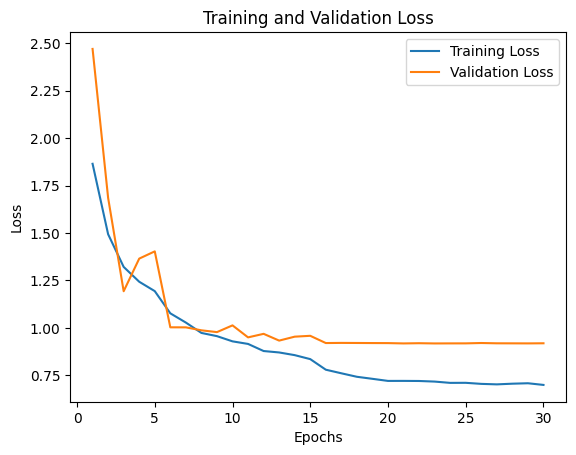

In [17]:
train_loss = ResNet50V2_history.history['loss']
val_loss = ResNet50V2_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

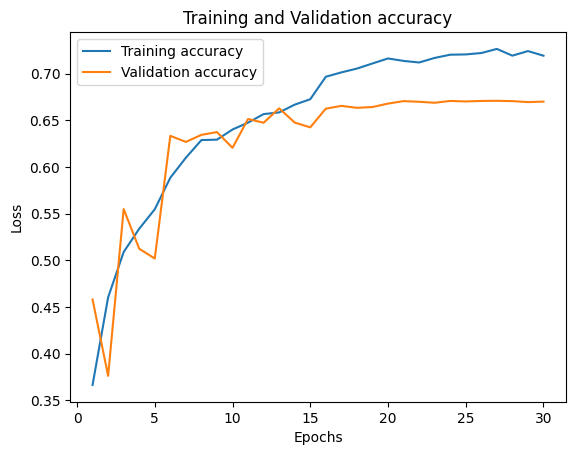

In [21]:
train_acc = ResNet50V2_history.history['accuracy']
val_acc = ResNet50V2_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation accuracy')
plt.legend()

plt.show()

In [22]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_generator)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 62s 547ms/step - loss: 0.9372 - accuracy: 0.6747
    Test Loss: 0.93721
Test Accuracy: 67.47%


113/113 [==============================] - 22s 190ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

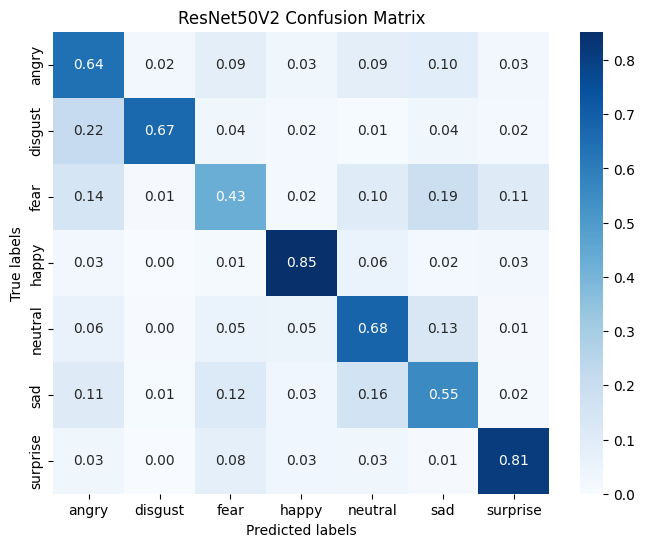

In [41]:
import seaborn as sns
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_generator)
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)
fig , ax= plt.subplots(figsize=(8,6))
class_labels = sorted(os.listdir(train_dir))
cm=confusion_matrix(test_generator.labels, ResNet50V2_Predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, cmap='Blues', annot=True, fmt='.2f', ax=ax,xticklabels=class_labels, yticklabels=class_labels)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('ResNet50V2 Confusion Matrix')

In [43]:
from sklearn.metrics import classification_report
true_labels=np.array(test_generator.labels)
report = classification_report(true_labels, ResNet50V2_Predictions, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.57      0.64      0.60       958
     disgust       0.59      0.67      0.62       111
        fear       0.53      0.43      0.47      1024
       happy       0.89      0.85      0.87      1774
     neutral       0.62      0.68      0.65      1233
         sad       0.58      0.55      0.57      1247
    surprise       0.75      0.81      0.78       831

    accuracy                           0.67      7178
   macro avg       0.65      0.66      0.65      7178
weighted avg       0.67      0.67      0.67      7178

